# **Image Classification Model Deployment**



Install Library

In [ ]:
import zipfile
import os
import glob 
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.preprocessing import image
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Load Data

Dataset : https://www.kaggle.com/brsdincer/vehicle-detection-image-set

Ekstrak File Zip

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/archive.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Mounted at /content/drive/


Mengatur lokasi dataset

In [ ]:
dir_dataset = "/tmp/data"
dir_vehicle = os.path.join("/tmp/data/vehicles")
dir_non_vehicle = os.path.join("/tmp/data/non-vehicles")

Mengecek jumlah data

In [ ]:

total_image = len(list(glob.iglob("/tmp/data/*/*.*", recursive=True)))
print("Total Data Image JPEG     : ",total_image)

total_vehicle = len(os.listdir(dir_vehicle))
total_non_vehicle = len(os.listdir(dir_non_vehicle))

print("Total Data Vehicle      : ",total_vehicle)
print("Total Data Non-Vehicle      : ",total_non_vehicle)

Total Data Image JPEG     :  17760
Total Data Vehicle      :  8792
Total Data Non-Vehicle      :  8968


## Image Data Generator Tensorflow untuk pengolahan gambar

In [ ]:
# Train dan Validation  data generator 
# Ukuran validation 20%

val_size = 0.2

Train_data_generator = ImageDataGenerator(
    rotation_range = 30,
    brightness_range = [0.2,1.0],
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = val_size
)

Validation_data_generator = ImageDataGenerator(
    rotation_range = 30,
    brightness_range = [0.2,1.0],
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = val_size
)

### Split Dataset

In [ ]:
image_width = 150
image_height = 150

Train_gen = Train_data_generator.flow_from_directory(
    dir_dataset,
    target_size = (image_width,image_height),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 16,
    shuffle = True,
    subset = "training"
)

Val_gen = Validation_data_generator.flow_from_directory(
    dir_dataset,
    target_size = (image_width,image_height),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 16,
    shuffle = False,
    subset = "validation"
)

Found 14209 images belonging to 2 classes.
Found 3551 images belonging to 2 classes.


## Modelling

In [ ]:
# Model dengan Sequential

Model = Sequential(
    [
     # Activation menggunakan relu + softmax
     Conv2D(32, (3,3), strides = (1,1), activation = 'relu' , input_shape = (image_width,image_height,3)),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Conv2D(64, (3,3), strides = (1,1), activation = 'relu' ),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Conv2D(128, (3,3), strides = (1,1), activation = 'relu' ),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Flatten(),

     # Droupout
     Dropout(0.2),
     
     Dense(128, activation = 'relu'),
     Dense(2, activation='softmax')
    ]
)

In [ ]:
# Optimizer
Adam(learning_rate=0.00146, name='Adam')
Model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
# Schedule dan Callback
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', embeddings_freq=0,
    embeddings_metadata=None
)

Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

### Training Model

In [ ]:
# Proses Training 
batch_size = 16

with tf.device("/device:GPU:0"):
  history = Model.fit(Train_gen, 
                    epochs =  10, 
                    steps_per_epoch = 1751//batch_size, 
                    validation_data = Val_gen, 
                    verbose = 1, 
                    validation_steps = 437//batch_size,
                    callbacks =[lr_schedule, tb_callback])

Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0006065307534299791.
109/109 [==============================] - 90s 822ms/step - loss: 0.1116 - accuracy: 0.9662 - val_loss: 0.2551 - val_accuracy: 0.8773
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0006065307534299791.
109/109 [==============================] - 91s 838ms/step - loss: 0.0642 - accuracy: 0.9776 - val_loss: 0.0338 - val_accuracy: 0.9907
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0006065307534299791.
109/109 [==============================] - 90s 824ms/step - loss: 0.0802 - accuracy: 0.9708 - val_loss: 0.1426 - val_accuracy: 0.9398
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0006065307534299791.
109/109 [==============================] - 90s 828ms/step - loss: 0.0677 - accuracy: 0.9776 - val_loss: 0.0310 - val_accuracy: 0.9884
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00060

### Plotting

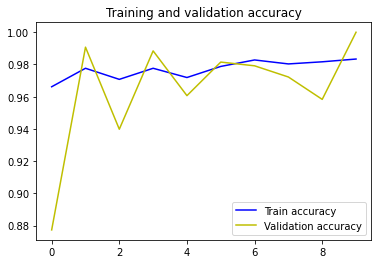

<Figure size 432x288 with 0 Axes>

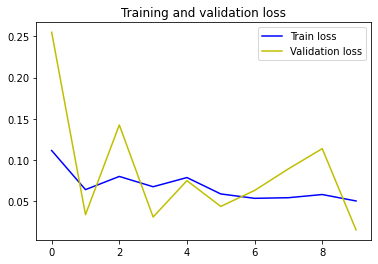

<Figure size 432x288 with 0 Axes>

In [ ]:
accuracy = history.history['accuracy']
validation_acc = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Train accuracy')
plt.plot(epochs, validation_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Train loss')
plt.plot(epochs, validation_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## Prediksi Gambar

Saving right (59).png to right (59).png


Hasil Prediksi :  [0. 1.] 

Kategori Gambar : Vehicles


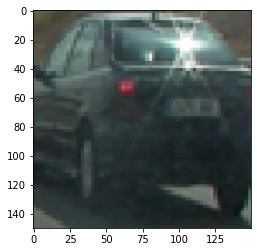

In [ ]:
uploaded = files.upload()

for file_upload in uploaded.keys():

  path = file_upload
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = Model.predict(images, batch_size=16)
  
  print("\n")
  print('Hasil Prediksi : ',classes[0],'\n')

  if classes[0][0] == 1:
    print('Kategori Gambar : Non-Vehicles')
  elif classes[0][1] == 1:
    print('Kategori Gambar : Vehicles')

## Export ke TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(Model)
tflite_model = converter.convert()

with open('Vehicles_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp4ykbcikz/assets
